In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tse-spacy-model/models2/model_neg/tokenizer
/kaggle/input/tse-spacy-model/models2/model_neg/meta.json
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/vectors
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/key2row
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/lexemes.bin
/kaggle/input/tse-spacy-model/models2/model_neg/vocab/strings.json
/kaggle/input/tse-spacy-model/models2/model_neg/ner/model
/kaggle/input/tse-spacy-model/models2/model_neg/ner/moves
/kaggle/input/tse-spacy-model/models2/model_neg/ner/cfg
/kaggle/input/tse-spacy-model/models/model_neg/tokenizer
/kaggle/input/tse-spacy-model/models/model_neg/meta.json
/kaggle/input/tse-spacy-model/models/model_neg/vocab/vectors
/kaggle/input/tse-spacy-model/models/model_neg/vocab/key2row
/kaggle/input/tse-spacy-model/models/model_neg/vocab/lexemes.bin
/kaggle/input/tse-spacy-model/models/model_neg/vocab/strings.json
/kaggle/input/tse-spacy-model/models/model_neg/ner/model
/kaggle/input/tse-spacy-model/m

**The goal of this notebook is to extract those words or phrase which determines the sentiment of whole tweet**


**1. About Tweet Sentiment Extraction Dataset**

The data folder contains following files, all in csv format Files

train.csv - the training set

test.csv - the test set

sample_submission.csv - a sample submission file in the correct format

**Columns**

textID - unique ID for each piece of text

text - the text of the tweet

sentiment - the general sentiment of the tweet

selected_text - [train only] the text that supports the tweet's sentiment

**2. Competition metric:**

The metric in this competition is the word-level Jaccard score. Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets. Let’s take example of two sentences:

Sentence 1: AI is our friend and it has been friendly

Sentence 2: AI and humans have always been friendly

In order to calculate similarity using Jaccard similarity, we will first perform lemmatization to reduce words to the same root word. In our case, “friend” and “friendly” will both become “friend”, “has” and “have” will both become “has”. Drawing a Venn diagram of the two sentences we get:

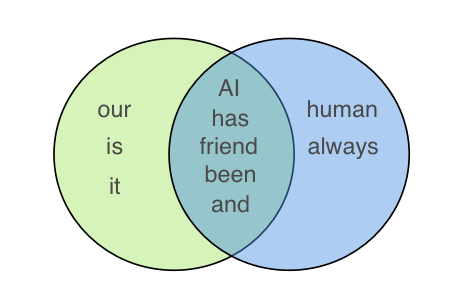

**3. Posing this problem as NER problem**

**What is NER?**

Named-entity recognition (NER) (also known as entity identification, entity chunking and entity extraction) is a subtask of information extraction that seeks to locate and classify named entity mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

In [2]:
# import important libraries
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings('ignore')


In [3]:
#reading data
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
submission_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')

In [4]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
train_df.shape

(27481, 4)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
train_df = train_df.dropna()

**3. Training Model**

To train a model from scratch pass model parameter as None
To resume training of a saved model pass model parameter as some_value

In [8]:
def save_model(output_dir, nlp,new_model_name):
    output_dir = f'../working/{output_dir}'
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("saved moodel to", output_dir)

In [9]:
nlp= spacy.blank('en')

In [10]:
nlp.create_pipe("ner")

In [11]:
from spacy.training.example import Example

In [12]:
# pass model = nlp if you want to train on top of existing model 

def train(train_data,output_dir,n_iter = 20,model = None):
    if model is not None:
        nlp = spacy.load(output_dir) #loading existing model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en') # create blank Language class
        print("created a blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe("ner",last = True)
        #otherwose get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")
        
    #add labels
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    #get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe!= "ner"]
    with nlp.disable_pipes(*other_pipes): #only train NER
        #batch up the examples using spacy's minibatch
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()
            
        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size = compounding(4.0,500.0,1.001))
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                
                example = []
                # Update the model with iterating each text
                for i in range(len(texts)):
                    doc = nlp.make_doc(texts[i])
                    example.append(Example.from_dict(doc, annotations[i]))

                # Update the model
                nlp.update(
                    example,
                    drop = 0.5, #dropout- make it harder to memorise data
                    losses = losses
                )
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')
    
        
    
    

In [13]:
def get_model_out_path(statement):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = 'models/model_pos'
    elif sentiment == 'negative':
        model_out_path = 'models/model_neg'
    else:
        model_out_path = 'models/model_neu'
    return model_out_path

In [14]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [15]:
# creating data on spacy data input format

def get_training_data(sentiment):
    train_data = []
    for index, row in train_df.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

**3.1 Traing for positive sentiment**

In [16]:
sentiment = 'positive'
train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# for demo purpose i am just training the model for 2 iterations, feel free to experiment.
train(train_data, model_path, n_iter=2, model=None)

[2024-02-20 17:53:26,028] [INFO] Created vocabulary
[2024-02-20 17:53:26,029] [INFO] Finished initializing nlp object


created a blank 'en' model


 50%|█████     | 1/2 [00:54<00:54, 54.54s/it]

Losses {'ner': 13157.619970847858}


100%|██████████| 2/2 [01:48<00:00, 54.40s/it]

Losses {'ner': 11935.121418795316}
saved moodel to ../working/models/model_pos


In [17]:
sentiment = 'negative'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# for demo purpose i am just training the model for 2 iterations, feel free to experiment.
train(train_data, model_path, n_iter=2, model=None)

[2024-02-20 17:55:17,643] [INFO] Created vocabulary
[2024-02-20 17:55:17,645] [INFO] Finished initializing nlp object


created a blank 'en' model


 50%|█████     | 1/2 [00:50<00:50, 50.90s/it]

Losses {'ner': 12704.401202738829}


100%|██████████| 2/2 [01:41<00:00, 50.94s/it]

Losses {'ner': 11458.609906486581}
saved moodel to ../working/models/model_neg


In [18]:
sentiment = 'neutral'

train_data = get_training_data(sentiment)
model_path = get_model_out_path(sentiment)

# for demo purpose i am just training the model for 2 iterations, feel free to experiment.
train(train_data, model_path, n_iter=2, model=None)

[2024-02-20 17:57:02,447] [INFO] Created vocabulary
[2024-02-20 17:57:02,449] [INFO] Finished initializing nlp object


created a blank 'en' model


 50%|█████     | 1/2 [01:05<01:05, 65.60s/it]

Losses {'ner': 5361.372951966236}


100%|██████████| 2/2 [02:11<00:00, 65.58s/it]

Losses {'ner': 2792.1137224176246}
saved moodel to ../working/models/model_neu


**4. jaccard score on train data**

In [19]:
TRAINED_MODELS_BASE_PATH = '/kaggle/working/models/'

In [20]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [21]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))
if TRAINED_MODELS_BASE_PATH is not None:
    print("Loading Models  from ", TRAINED_MODELS_BASE_PATH)
    model_pos = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_neg')
    model_neu = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_neu')
        
    jaccard_score = 0
    for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        text = row.text
        if row.sentiment == 'neutral':
            jaccard_score += jaccard(predict_entities(text, model_neu), row.selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard(predict_entities(text, model_pos), row.selected_text)
        else:
            jaccard_score += jaccard(predict_entities(text, model_neg), row.selected_text) 
        
    print(f'Average Jaccard Score is {jaccard_score / train_df.shape[0]}') 

Loading Models  from  /kaggle/working/models/


100%|██████████| 27480/27480 [02:07<00:00, 215.90it/s]

Average Jaccard Score is 0.6237170667515359
